# Eval and Function Analysis

This notebook looks at 8 aspects of the "script_loc_eval" row in the crawl dataset:
1. How many websites, and what % of websites, use eval 1 or more times.
2. For all the websites that use eval 1 or more times, How many times is eval used by these website and what % of total function calls are eval calls.
3. The number of unique scripts that use eval.
4. Out of the scripts on websites that use eval, how many scripts are 3rd party scripts.
5. Summary statistics about the # of eval calls per website.
6. A visualization of the distribution of the # of eval calls.
7. A visualization of the distribution of the % of function calls for a website that are created using eval.
8. A visualization of the relationship between the # of eval calls and the % of function calls that are created using eval.

In [18]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd

from utils import load_data_util

%matplotlib inline

In [2]:
files_to_analyze = 10000
data = load_data_util.load_random_data(files_to_analyze, False, 42, False)

#### Build a dictionary with webpage urls as keys and eval information as the values.

In [19]:
result = {}
for index, row in data.iterrows():
    # get the url of the webpage that was being crawled and use that as a unique key.
    key = row['location']

    if key not in result:
        result[key] = {
            "count": 0,
            "total_func_calls": 0,
            "script_urls": {}
        }

    if row['script_loc_eval'] != "":
        result[key]["count"] += 1
        
        script_url = row['script_url']
        result[key]["script_urls"][script_url] = result[key]["script_urls"].get(script_url, 1) + 1
    result[key]["total_func_calls"] += 1

### Analyze the collected data to get:
* The number of websites with atleast 1 eval call.
* The number of scripts that use eval and are not hosted on the same domain as the website calling that script.
* A list with all the scripts that have functions created using eval.
* A DataFrame with the url for websites that have 1 or more function created using eval. The DataFrame contains the # of eval calls for that website and the % of function calls that were created using eval.

In [20]:
websites_with_eval_calls = 0
external_script_count = 0
script_urls = []
eval_usage = pd.DataFrame(columns=['url', '# of eval calls', '% of eval calls'])

for key in result:
    if result[key]['count'] > 0:
        websites_with_eval_calls += 1
        
        eval_call_count = result[key]['count']
        eval_call_percent = round(result[key]['count'] / result[key]['total_func_calls'] * 100, 2)
        
        eval_usage = eval_usage.append({
            "url": key,
            "# of eval calls": eval_call_count,
            "% of eval calls": eval_call_percent
        }, ignore_index=True)
        
        for script_url in result[key]["script_urls"]:
            script_urls.append(script_url)
            
            location_base_url = key.split("://")[1].split("/")[0]
            script_base_url = script_url.split("://")[1].split("/")[0]
            
            if location_base_url != script_base_url:
                external_script_count += 1

# set '# of eval calls' to be int type since it was being set to object type.
# without this change later analysis and visualizations do not work.
eval_usage['# of eval calls'] = eval_usage['# of eval calls'].astype("int")

#### Display how many websites have 1 or more function created using eval and what % of total websites have functions create using eval.

In [21]:
percentage_of_websites_with_eval_calls = round(websites_with_eval_calls / files_to_analyze * 100, 2)

print(
    str(percentage_of_websites_with_eval_calls) + "% (" + 
    str(websites_with_eval_calls) + "/" + str(files_to_analyze) + 
    ") of websites have 1 or more function that is created using eval."
)

8.98% (898/10000) of websites have 1 or more function that is created using eval.


#### Display the number of eval calls and % of function calls that are created using eval for all the websites with 1 or more eval calls.

In [22]:
print(eval_usage.sort_values(by=['# of eval calls'], ascending=False))

                                                   url  # of eval calls  % of eval calls
774        https://www.rezultati.com/nogomet/portugal/             1213            90.66
585  https://www.flashscore.pl/pilka-nozna/honduras...             1074            91.95
891  https://www.canliskor3.com/futbol/avrupa/sampi...              994            92.47
655  https://www.flashscore.com/soccer/netherlands/...              876            86.48
545  https://www.mismarcadores.com/futbol/espana/la...              833            88.43
241         https://www.soccerstand.com/soccer/uganda/              600            84.63
360    http://www.marksandspencer.com/l/lingerie/socks              427            54.95
33   https://particuliers.lcl.fr/quotidien/gestion-...              412            74.91
646          https://www.myscore.com.ua/football/peru/              360            82.57
510           https://www.flashscore.com/soccer/world/              348            81.50
1      https://www.me

#### Display the number of unique scripts that call a function created using eval.

In [23]:
total_script_urls = len(script_urls)
unique_script_urls = len(set(script_urls))
percentage_of_unique_script_urls = round(unique_script_urls / total_script_urls * 100, 2)

print(
    str(percentage_of_unique_script_urls) + "% (" + 
    str(unique_script_urls) + "/" + str(total_script_urls) + 
    ") of the scripts that use eval are unique."
)

55.3% (558/1009) of the scripts that use eval are unique.


#### Display the number of scripts that are hosted on a 3rd parties domain.

In [24]:
percentage_of_external_scripts = round(external_script_count / total_script_urls * 100, 2)

print(
    str(percentage_of_external_scripts) + "% (" + 
    str(external_script_count) + "/" + str(total_script_urls) + 
    ") of scripts that use eval are hosted on a different domain than the source website."
)

72.75% (734/1009) of scripts that use eval are hosted on a different domain than the source website.


#### Print summary statistics for # of eval calls

In [25]:
standard_deviation = round(eval_usage['# of eval calls'].std(), 2)
mean = round(eval_usage['# of eval calls'].mean(), 2)
median = round(eval_usage['# of eval calls'].median(), 2)

print('median = ' + str(median))
print('standard deviation = ' + str(standard_deviation))
print('average = ' + str(mean))

median = 3.0
standard deviation = 85.62
average = 19.97


#### Visualize how many websites have a given number of eval calls.

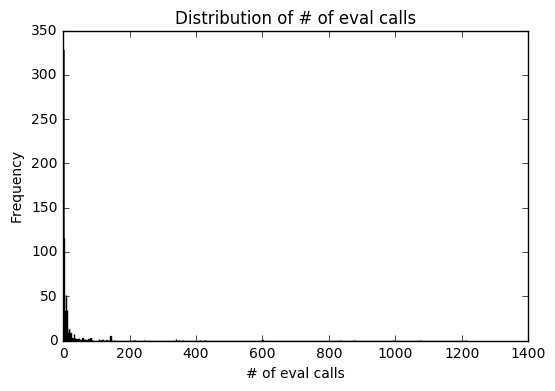

In [26]:
largest_eval_call_count = eval_usage['# of eval calls'].max()
plt.figure()

fig = eval_usage['# of eval calls'].plot.hist(bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")

plt.show()
plt.close()

Since the number of eval calls are so spread out, we cannot see much from the above graph other than that the majority of websites have a low number of eval calls.  Thus, to better visualize the data, we create a second histogram that looks at the frequency of websites where the number of eval calls is 2 standard deviations above 0. Since a large number of websites only have 1 eval call, we use a log scale so that all the data can be seen.

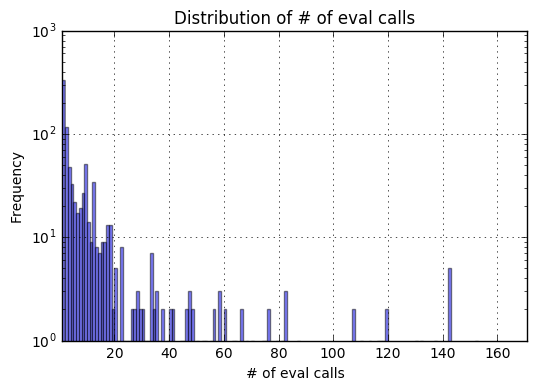

In [28]:
plt.figure()

fig = eval_usage['# of eval calls'].plot.hist(alpha=0.5, bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")
plt.yscale('log')
fig.set_xlim(1, int(standard_deviation * 2))
fig.grid()

plt.show()
plt.close()

Since the standard deviation is large we look at the first 1/4th of a standard deviation of eval calls to better visualize the histogram bins.

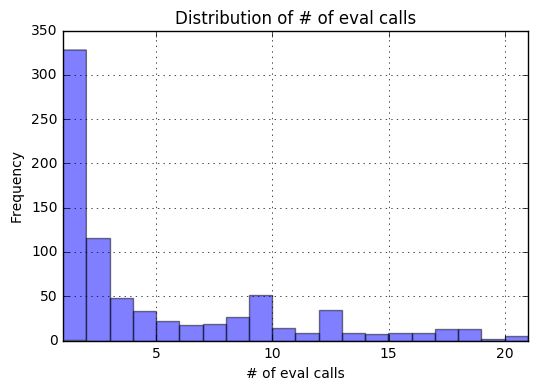

In [30]:
plt.figure()

fig = eval_usage['# of eval calls'].plot.hist(alpha=0.5, bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")
fig.set_xlim(1, int(standard_deviation / 4))
fig.grid();

plt.show()
plt.close()

#### Visualize the distribution of the % of function calls, created using eval, that the websites make.

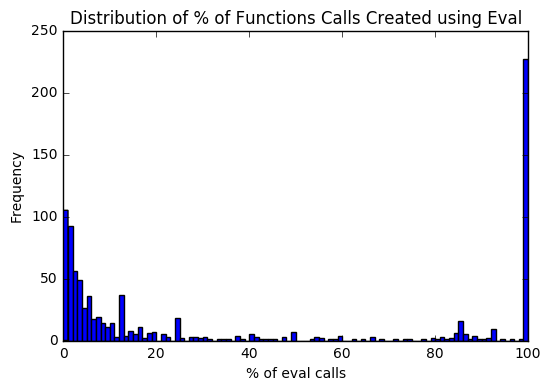

In [13]:
plt.figure()

fig = eval_usage['% of eval calls'].plot.hist(bins=100)

plt.title("Distribution of % of Functions Calls Created using Eval")
fig.set_xlabel("% of eval calls")

plt.show()
plt.close()

#### Visualize the relationship between the number of eval calls and the % of functions on the website that are created using eval.

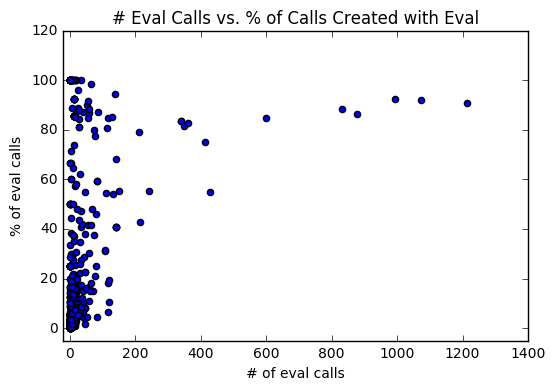

In [17]:
plt.figure()

fig = eval_usage.plot.scatter(x='# of eval calls', y='% of eval calls');

plt.title("# Eval Calls vs. % of Calls Created with Eval")
# set the x and y bounds so that they are slightly less than 1 so that the dots can be seen better.
fig.set_xlim(-20)
fig.set_ylim(-5)

plt.show()
plt.close()